# Demonstration of optimal design of experiments

In this document, we show how to generate optimal design of experiments with OpenTURNS. We focus on space-filling designs, which are a key point for many metamodels, especially kriging.

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
X = ot.Uniform(0, 1)
dim = 6
myDistribution = ot.ComposedDistribution([X] * dim)
n = 15

In [3]:
def drawPairs(sample, description, sampleSize):
    """Draw a Pairs plot, with a description"""
    graph = ot.VisualTest_DrawPairs(sample)
    graph.setTitle("%s, n=%d" % (description, sampleSize))
    view = otv.View(graph)
    figure = view.getFigure()
    figure.set_size_inches((9.0, 9.0))
    axes = figure.get_axes()
    for a in axes:
        a.set_xlim(xmin = 0.0, xmax = 1.0)
        a.set_ylim(ymin = 0.0, ymax = 1.0)
    return view

## Simple Monte-Carlo sample

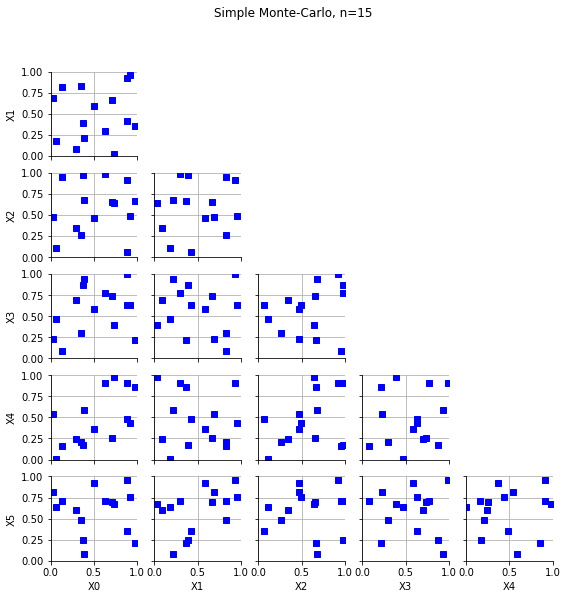

In [4]:
sample = myDistribution.getSample(n)
view = drawPairs(sample, "Simple Monte-Carlo", n)

We observe that this design of experiments has holes and clusters. This implies that this design does not fill the space very well.

## Latin Hypercube Sample

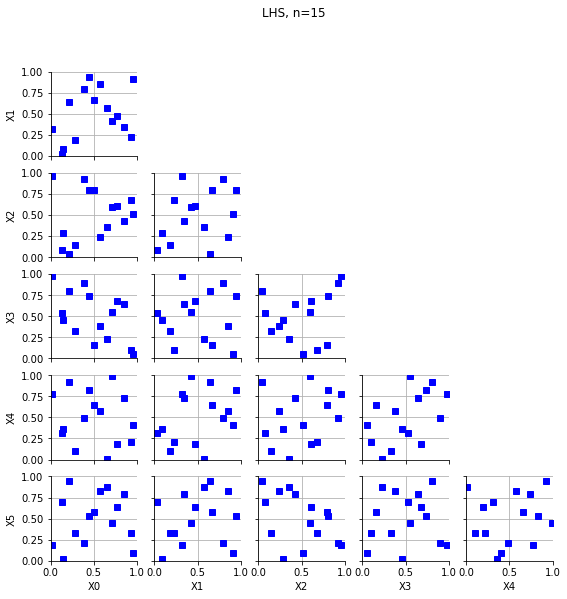

In [5]:
experiment = ot.LHSExperiment(myDistribution, n)
sample = experiment.generate()
view = drawPairs(sample, "LHS", n)

We see that the LHS design fills more the space than the Monte-Carlo sampling. However, there are still empty zones and clusters. 

## Optimized LHS with Simulated Annealing

In [6]:
lhs = ot.LHSExperiment(myDistribution, n)
lhs.setAlwaysShuffle(True)  # randomized
# Defining space fillings
spaceFilling = ot.SpaceFillingC2()
# Geometric profile
geomProfile = ot.GeometricProfile(10.0, 0.95, 2000)
# Simulated Annealing LHS with geometric temperature profile, C2 optimization
optimalLHSAlgorithm = ot.SimulatedAnnealingLHS(lhs, spaceFilling, geomProfile)

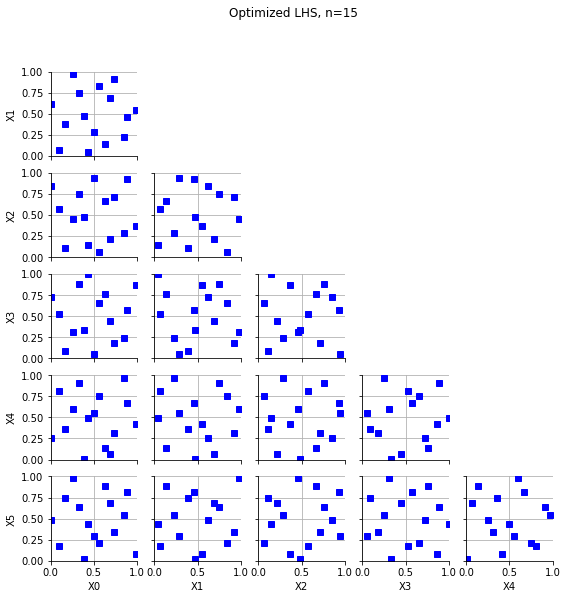

In [7]:
sample = optimalLHSAlgorithm.generate()
view = drawPairs(sample, "Optimized LHS", n)

This optimized LHS is better at filling the space than the basic LHS: there are not large holes anymore.

## Low discrepancy sequence

In [8]:
sequence = ot.SobolSequence()
mydoe = ot.LowDiscrepancyExperiment(sequence, myDistribution, n, False)

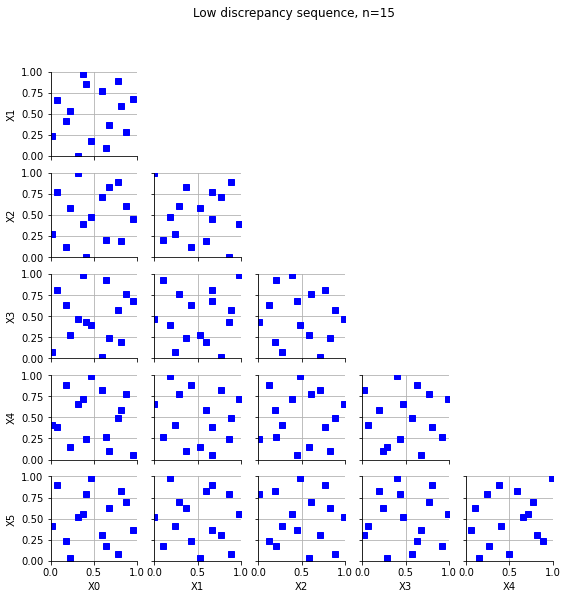

In [9]:
sample = mydoe.generate()
sample = optimalLHSAlgorithm.generate()
view = drawPairs(sample, "Low discrepancy sequence", n)

We see that a low discrepance sequence fills the space quite well.

## Optimized low discrepancy sequence

In [10]:
def optimizedExperiment(designOfExperiment, criteria, itermax=10000):
    """Generates itermax samples from the designOfExperiment and 
    returns the sample which optimizes the criteria."""
    isMinProblem = criteria.isMinimizationProblem()
    if isMinProblem:
        criteria_best = 1.0
    else:
        criteria_best = 0.0
    bestInputTrain = None
    for i in range(itermax):
        sample = designOfExperiment.generate()
        criteria_value = criteria.evaluate(sample)
        if isMinProblem and (criteria_value < criteria_best):
            criteria_best = criteria_value
            bestSample = sample
        elif not (isMinProblem) and (criteria_value > criteria_best):
            criteria_best = criteria_value
            bestSample = sample
    return bestSample, criteria_best

The MinDist criteria must be maximized.

In [11]:
criteria = ot.SpaceFillingMinDist()
isMinProblem = criteria.isMinimizationProblem()
isMinProblem

False

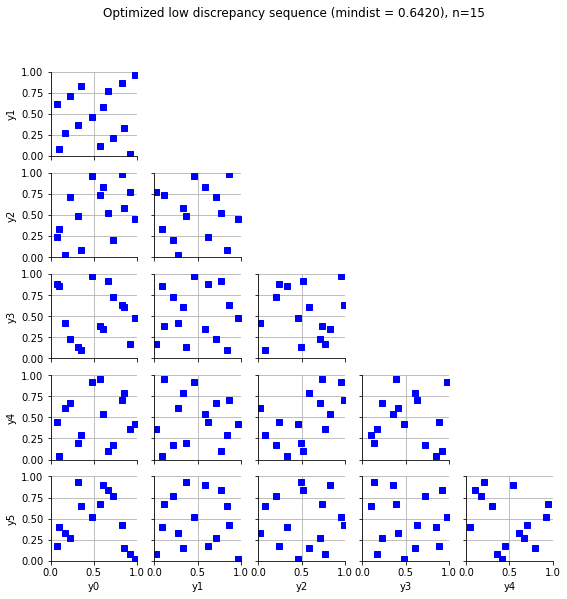

In [12]:
sequence = ot.SobolSequence()
mydoe = ot.LowDiscrepancyExperiment(sequence, myDistribution, n, False)
sample, mindistvalue = optimizedExperiment(mydoe, criteria)
view = drawPairs(
    sample, "Optimized low discrepancy sequence (mindist = %.4f)" % (mindistvalue), n
)

The difficulty using 2D projections to quantify the space filling property is that the multidimensionna mindist criteria might be optimized, while having poor 2D projections. 

The C2 criteria has to be minimized.

In [13]:
criteria = ot.SpaceFillingC2()
isMinProblem = criteria.isMinimizationProblem()
isMinProblem

True

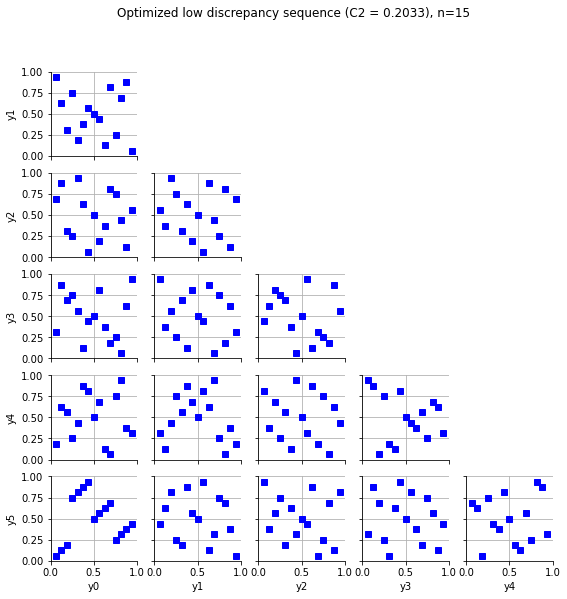

In [14]:
sequence = ot.SobolSequence()
mydoe = ot.LowDiscrepancyExperiment(sequence, myDistribution, n, False)
sample, mindistvalue = optimizedExperiment(mydoe, criteria)
view = drawPairs(sample, "Optimized low discrepancy sequence (C2 = %.4f)" % (mindistvalue), n)

There is an obvious pattern in this design.